# Defect Prediction on production lines by VALEO
# Challenge context
Valeo is a French global automotive supplier headquartered in France, listed on the Paris Stock Exchange (CAC-40 Index). It supplies a wide range of products to automakers and the aftermarket. The Group employs 113,600 people in 33 countries worldwide. It has 186 production plants, 59 R&D centers and 15 distribution platforms. Its strategy is focused on innovation and development in high-growth potential regions and emerging countries. Valeo ranked as France's leading patent filer from 2016 to 2018.
 
# Challenge goals
The goal of the challenge is to predict defect on starter motor production lines. During production samples assembly, different values (torques, angles ...) are measured on different mounting stations. At the end of the line, additional measures are performed on two test benches in order to isolate defects. As a result, samples are tagged ‘OK’, ‘KO’. We would like to design a model that could identify such defects before the test bench step.

# Data description
**ID** = PROC_TRACEINFO = it’s a unique code given to the product. Example : I-B-XA1207672-190701-00494.

XA1207672 is the reference.
190701 is the date: here 01st of July of year 2019.
00494 is the unique code given to the product, whatever it happens, the product will have this id number frozen forever.
This number is increased by 1 each time we process a new product, every 12s. So for example : I-B-XA1207672-190701-00495 is the next product.

**Inputs** : Input features are measures collected on different assembly stations with the sensors or devices connected to Programmable Logic Controllers which are storing all of them to keep the full quality traceability. (Examples : OP070_V_1_angle_value, OP120_Rodage_I_value, etc…).

**Output** : This is the result value of OP130 (test bench). Value 0 is assigned to OK samples (passed) and value 1 is assigned to KO samples (failed). This is the combined result of multiple electrical, acoustic and vibro-acoustic tests.

**The target** is to find the best prediction : Output = f (inputs). The dataset contains 34515 training samples and 8001 test samples.

# Benchmark description
We expect a AUROC more than 0.675 which can easily be obtained with a basic **Naive Bayes classifier**. This AUROC value had been obtained using some techniques for unbalanced classes handling and not only with the challenge metric. That's the main reason why our AUROC value of 0.675 is different from the benchmark value (0.5904).

***

# 2. Data Pre-processing

In [3]:
from IPython.core.interactiveshell import InteractiveShell 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
nb_path = os.path.abspath(".")

In [4]:
nb_path = os.path.abspath(".")
InteractiveShell.ast_node_interactivity = "all"
sns.set(color_codes=True)

In [101]:
X_validation = pd.read_csv(os.path.join(nb_path,"testinputs.csv")) 
dataset = pd.read_csv(os.path.join(nb_path,"traininginputs.csv")).merge(pd.read_csv(os.path.join(nb_path,"trainingoutput.csv")), on="PROC_TRACEINFO")

In [102]:
target = "Binar OP130_Resultat_Global_v"
code = "PROC_TRACEINFO"

In [103]:
from sklearn.model_selection import train_test_split

In [104]:
trainset, testset = train_test_split(dataset, test_size=0.2, random_state=0)

In [113]:
def imputation(df):
    #df["is na"] = df["OP100_Capuchon_insertion_mesure"].isna()
    # outliers handling
    # fill na with smote
    # fill na with knn
    # df = df.dropna(axis=0)
    df = df.drop("OP100_Capuchon_insertion_mesure", axis=1)
    return df

In [106]:
def preprocessing(df):
    df = imputation(df)
    
    X = df.drop([target,code], axis=1)
    y = df[target]
    
    print(y.value_counts())
    
    return X, y

In [114]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

0    27374
1      238
Name: Binar OP130_Resultat_Global_v, dtype: int64
0    6836
1      67
Name: Binar OP130_Resultat_Global_v, dtype: int64


# 3. Model Building

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

In [126]:
model = make_pipeline(SelectKBest(f_classif, k=5), RandomForestClassifier(random_state=0))

In [117]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [118]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    

[[6818   18]
 [  67    0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6836
           1       0.00      0.00      0.00        67

    accuracy                           0.99      6903
   macro avg       0.50      0.50      0.50      6903
weighted avg       0.98      0.99      0.98      6903



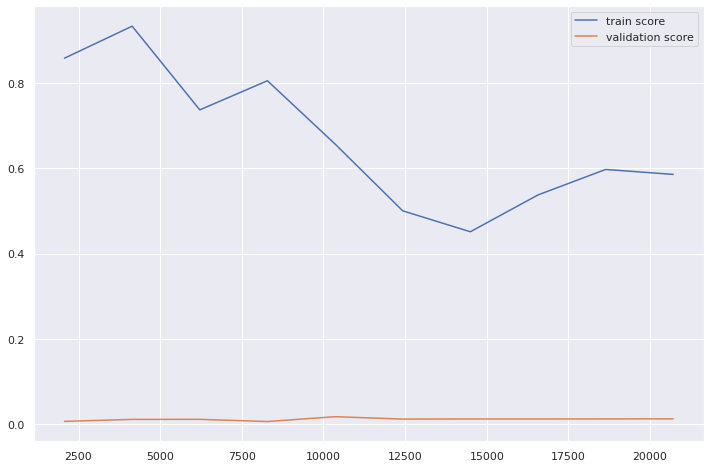

In [127]:
evaluation(model)

In [120]:
dataset.columns  

Index(['PROC_TRACEINFO', 'OP070_V_1_angle_value',
       'OP090_SnapRingPeakForce_value', 'OP070_V_2_angle_value',
       'OP120_Rodage_I_mesure_value', 'OP090_SnapRingFinalStroke_value',
       'OP110_Vissage_M8_torque_value', 'OP100_Capuchon_insertion_mesure',
       'OP120_Rodage_U_mesure_value', 'OP070_V_1_torque_value',
       'OP090_StartLinePeakForce_value', 'OP110_Vissage_M8_angle_value',
       'OP090_SnapRingMidPointForce_val', 'OP070_V_2_torque_value',
       'Binar OP130_Resultat_Global_v'],
      dtype='object')

<AxesSubplot:>

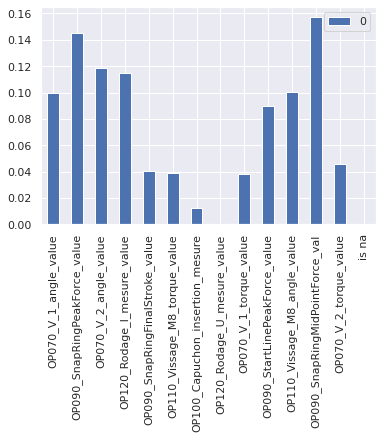

In [98]:
pd.DataFrame(model.feature_importances_, index=X_train.columns).plot.bar()